# **Modelo # 1.  Enfermos - No Enfermo**

# **Conexion Google Drive** *texto en cursiva*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importaciones y Loading de la Data**

In [ ]:
# Paquetes requeridos

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain

import tensorflow
#import keras
import tensorflow.keras
import sklearn
import sklearn as sk

from sklearn.model_selection import train_test_split


from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


In [ ]:
from platform import python_version
print('Python:', python_version())
#print('tensowflow:', tensorflow.__version__)
#print('keras: ', keras.__version__)

print(f"Tensor Flow Version: {tensorflow.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
#print(f"Python {system.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tensorflow.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python: 3.7.12
Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Pandas 1.1.5
Scikit-Learn 0.22.2.post1
GPU is NOT AVAILABLE


In [ ]:
# Experiment name
model_name = 'VGG16'

## **Load Data, Encoding  y Unificar clases iguales**
1. Columna conteo de enfermedades por placa ('count_diseases') y columna de si esta enfermo ('Enfermo')
2. Se hace un encoding por cada enfermedad reportada en la columna 'Finding Labels'
3. Ejemplo: **(Infiltration|Effusion')**	y **(Effusion|Infiltration')** --> se volveran una misma clase y se genera nueva columna ('FIXED_LABELS') 

In [ ]:
## Carpeta de los datos
data_folder = '/content/drive/MyDrive/Proyecto_Lewagon_Rayos_X'
## importar DF 
xray_df = pd.read_csv(data_folder + '/Data_Entry_2017.csv')

In [ ]:
nRow, nCol = xray_df.shape

xray_df.drop(columns= 'Unnamed: 11', inplace=True )
print(f' hay {nRow} rows  y {nCol} columnas')

 hay 112120 rows  y 12 columnas


In [ ]:
# Generacion columna conteo de enfermedades por imagen 
xray_df['count_diseases'] = xray_df['Finding Labels'].map(lambda x: len(x.split('|')))
xray_df['Count_diseases'] = np.where(xray_df['Finding Labels'] =='No Finding', 0,xray_df['count_diseases'] )

In [ ]:
# Generacion columna enfermo_noenfermo --> 1 es enfermo - 0 es No enfermo 
xray_df['Enfermo'] = np.where(xray_df['Count_diseases'] ==0, 0,1)

# eliminar columna count_diseases
xray_df.drop(columns= 'count_diseases', inplace=True )


In [ ]:
# encoding multiple 
all_labels = np.unique(list(chain(*xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        xray_df[c_label] = xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

xray_df.sample(3)    

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Count_diseases,Enfermo,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
13326,00003463_001.png,No Finding,1,3463,66,M,AP,2500,2048,0.168,0.168,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
48460,00012291_001.png,No Finding,1,12291,52,M,PA,2992,2991,0.143,0.143,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
32054,00008384_000.png,No Finding,0,8384,36,M,PA,2992,2991,0.143,0.143,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# cambiar de float a integer 
cols = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 
        'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 
        'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

xray_df[cols] = xray_df[cols].applymap(np.int64)

In [ ]:
# numero de unique values de las clases (deberian quedar menos de 836)
num_clases = xray_df['Finding Labels'].nunique()
print('Existen',num_clases,'clases en el dataset' )

Existen 836 clases en el dataset


In [ ]:
xray_df['Combined']= xray_df[cols].values.tolist()

xray_df['Fixed_Labels'] = xray_df['Combined'].apply(
    lambda x: '|'.join([cols[i] for i, val in enumerate(x) if val == 1]))

num_clases = xray_df['Fixed_Labels'].nunique()
print('Quedaron',num_clases,'clases en el dataset' )

Quedaron 801 clases en el dataset


In [ ]:
# borrar la columna combined (no sirve)
# borrar Finding Labels
xray_df.drop(columns= ['Combined','Finding Labels'], inplace=True )

# **Eliminar pacientes sin sentido (EDAD)**

In [ ]:
print('Rows en el dataset:',xray_df.shape[0])
# se eliminan 16 pacientes 
index_mayor100 = list(xray_df[xray_df['Patient Age'] > 100].index)
xray_df = xray_df.drop(index_mayor100)
print('Rows en el dataset luego de eliminar pacientes mayores a 100:',xray_df.shape[0])

Rows en el dataset: 112120
Rows en el dataset luego de eliminar pacientes mayores a 100: 112104


# **Elegir clases con las que vamos a Trabajar**

In [ ]:
enfermos =  xray_df[xray_df['Enfermo'] == 1]

In [ ]:
# elegir las clases multiples con mas de 1000 
enfermos_mult = enfermos[enfermos['Count_diseases']>=2]
enfermos_mult = enfermos_mult['Fixed_Labels'].value_counts().to_frame()
enfermos_mult = enfermos_mult[enfermos_mult['Fixed_Labels'] > 1000]
mult_clases = list(enfermos_mult.index)
print(mult_clases)
enfermos_mult

['Effusion|Infiltration', 'Atelectasis|Infiltration', 'Atelectasis|Effusion']


,Fixed_Labels
Effusion|Infiltration,1604
Atelectasis|Infiltration,1350
Atelectasis|Effusion,1167


In [ ]:
# Elegir las mono-clases  
enfermos_mono = enfermos[enfermos['Count_diseases']<2]
enfermos_mono = enfermos_mono['Fixed_Labels'].value_counts(normalize=True).to_frame()
enfermos_mono = enfermos_mono[enfermos_mono['Fixed_Labels'] > 0.01]
mono_clases  = list(enfermos_mono.index)

In [ ]:
clases_enfermedades = mono_clases + mult_clases
clases_enfermedades

['Infiltration',
 'Atelectasis',
 'Effusion',
 'Nodule',
 'Pneumothorax',
 'Mass',
 'Consolidation',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Emphysema',
 'Fibrosis',
 'Edema',
 'Pneumonia',
 'Effusion|Infiltration',
 'Atelectasis|Infiltration',
 'Atelectasis|Effusion']

In [ ]:
# cantidad datos eliminados de los enfermos 
eliminados = enfermos.shape[0] - xray_df[xray_df['Fixed_Labels'].isin(clases_enfermedades)].shape[0]
print('Se eliminarian',eliminados,'del dataframe' )

no_enfermos =  xray_df[xray_df['Enfermo'] == 0]
enfermos_noenfermos = xray_df[xray_df['Fixed_Labels'].isin(clases_enfermedades)].shape[0] + no_enfermos.shape[0]
print('Total imagenes dataset final:',enfermos_noenfermos)

Se eliminarian 16781 del dataframe
Total imagenes dataset final: 95323


# **Generar Columna Path imagen** 

In [ ]:
## agregar columna con el path de cada imagen 
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(data_folder,'images*', 'images', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', xray_df.shape[0])
xray_df['path'] = xray_df['Image Index'].map(all_image_paths.get)

print(xray_df.columns)
xray_df.shape[0]


Scans found: 112150 , Total Headers 112104
Index(['Image Index', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]',
       'OriginalImagePixelSpacing[x', 'y]', 'Count_diseases', 'Enfermo',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax',
       'Fixed_Labels', 'path'],
      dtype='object')


112104

In [ ]:
# verificacion 
df_nan = xray_df[xray_df['path'].isna()]
df_nan

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Count_diseases,Enfermo,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Fixed_Labels,path


In [ ]:
# La data ya esta balanceada 
xray_df['Enfermo'].value_counts()

0    60353
1    51751
Name: Enfermo, dtype: int64

# **Train test split y reshaping**

In [ ]:
# Dividir el conjunto de datos balanceado
train_val_df, test_df = train_test_split(xray_df, test_size = 0.2)
train_df, val_df = train_test_split(train_val_df, test_size = 0.125) # 11.210 para la validacion conservar el 10% del total 
 
print('rows train_df:',train_df.shape[0])

print('rows val_df:',val_df.shape[0])

print('rows test_df:',test_df.shape[0])

rows train_df: 78472
rows val_df: 11211
rows test_df: 22421


In [ ]:
# reshaping 
train_df = train_df/255.0
test_df = test_df/255.0
val_df =val_df/255.0

TypeError: ignored

## Aumentación de datos

- Aumentar el conjunto de entrenamiento. Aqui utilizaremos el generador de datos estándar de Keras.
- Establecer un conjunto de validación.
- Visualizar algunos ejemplos del conjunto aumentado.


In [ ]:
#Hiperparámetros
batch_size = 200

# Parametros
IMG_SIZE = (224, 224)

In [ ]:
# Como la data esta balanceada SOLO se pasa el rescaler 
# Data Generator for training includes random modifications to the images
my_idg = ImageDataGenerator(rescale=1. / 255.0)

# Data generator for validation does not include random modifications
my_idg_no_augmentation =  / 255.0)

train_gen = my_idg.flow_from_dataframe(  dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'enfermo',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = batch_size
                                         )

val_gen = my_idg_no_augmentation.flow_from_dataframe(dataframe=valid_df, 
                                  directory=None, 
                                  x_col = 'path',
                                  y_col = 'enfermo',
                                  class_mode = 'binary',
                                  target_size = IMG_SIZE, 
                                  batch_size = batch_size
                                  )

TypeError: ignored

In [ ]:
## Pare realizar la validación del entrenamiento utilizaremos un lote de tamaño batch-size
valX, valY = val_gen.next()
print(valY)

NameError: ignored

In [ ]:
## Visualizar imagenes aumentadas
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('enfermo')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

NameError: ignored

# Aprendizaje por transferencia

El aprendizaje por transferencia (*transfer learning*) utiliza el conocimiento adquirido en una tarea para resolver una tarea relativamente similar. En el caso del aprendizaje profundo el conocimiento está representado en los pesos de una red neuronal, estos pesos se ajustan en una primera tarea y se reutilizan para resolver otra. En este caso se utiliza aprendizaje por transferencia para realizar la clasificación de imágenes de rayos x del pecho en las categorías de Neumonía o no-neumonía. 

El notebook a continuación presenta la implementación del aprendizaje utilizando la red entrenada VGG en la clasificación de las imágenes contenidas en el NIH-chest ray dataset. 

# Construcción del modelo

Utilizaremos la arquitectura de VGG16 preentrenada con el conjunto de datos de ImageNet. 

![Drag Racing](https://github.com/jhon2301922021/neumonitor/blob/main/transfer.png?raw=1)

En verde se muestra el modelo reutilizado, en azul los componentes congelados y en naranja los componentes a entrenar.

Los siguientes pasos son:
- Instanciar el modelo
- Descargar y asignar los pesos
- Eliminar la capa completamente conectada y mantener las capas convolucionales con sus respectivos pesos
- Agregar cuatro capas completamente conectadas con pesos aleatorios

In [ ]:
#intanciar el modelo vgg16 incluimos la parte conentada y los pesos estas inicializados con el entrenamiento de imagen net
modelo_original = VGG16(include_top = True, weights='imagenet')
modelo_original.summary()

553476096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
# Obtiene la capa dado su nombre o índice donde block5_pool es la ultima capa donde ya termina toda la capa convulucional
transfer_layer = modelo_original.get_layer('block5_pool')

# Agrupa las capas en un solo objeto entrenable.se comportta como capas  congeladas
# "Model groups layers into an object with training and inference features."
modelo_reutilizado = Model(inputs=modelo_original.input,
                   outputs=transfer_layer.output)

# Congelar los pesos hasta la penúltima capa convolucional
for layer in modelo_reutilizado.layers[0:17]:
    layer.trainable = False
    
for layer in modelo_reutilizado.layers:
    print(layer.name, layer.trainable)
 # modificar que capas de pueden hacer fijas para mejora el resultado de la clasificacion   

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [ ]:
# el objeto sequential le podemos agregar diferentes cpas 
modelo_personalizado = Sequential()

# Add the convolutional part of the VGG16 model from above.
modelo_personalizado.add(modelo_reutilizado)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
modelo_personalizado.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
modelo_personalizado.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
modelo_personalizado.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
modelo_personalizado.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
modelo_personalizado.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
modelo_personalizado.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
modelo_personalizado.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
modelo_personalizado.add(Dense(1, activation='sigmoid'))

## Establecer optimizador 

- Hay diversos optimizadores, Adam selecciona el valor del learning rate de forma automática conforme avanzan las épocas. 
- La métrica de pérdida es entropía cruzada binaria.
- Compilar modelo

In [ ]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [ ]:
modelo_personalizado.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
## Verificar que está entrenando
modelo_personalizado.fit_generator(train_gen, 
                                  validation_data = (valX, valY), 
                                  epochs = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 12 steps, validate on 200 samples
12/12 [==============================] - 42s 4s/step - loss: 0.7990 - binary_accuracy: 0.4985 - val_loss: 0.6993 - val_binary_accuracy: 0.5050


In [ ]:
## Funciones callbakcs para guardar 

# archivos de mejores pesos
weight_path="{}_my_model.best.hdf5".format('xray_class')

# guardar los pesos dependiendo de la mejora
checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

# Si no mejora en 'patience' epocas terminar el entrenamiento
early = EarlyStopping( monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

## Entrenar!

In [ ]:
epochs = 100

In [ ]:
history = modelo_personalizado.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = epochs, 
                           callbacks = callbacks_list)


  ...
    to  
  ['...']
Train for 12 steps, validate on 200 samples
Epoch 1/100
11/12 [==========================>...] - ETA: 3s - loss: 0.7319 - binary_accuracy: 0.5079
Epoch 00001: val_loss improved from inf to 0.68902, saving model to xray_class_my_model.best.hdf5
12/12 [==============================] - 39s 3s/step - loss: 0.7296 - binary_accuracy: 0.5129 - val_loss: 0.6890 - val_binary_accuracy: 0.5250
Epoch 2/100
11/12 [==========================>...] - ETA: 3s - loss: 0.7253 - binary_accuracy: 0.5256
Epoch 00002: val_loss improved from 0.68902 to 0.68395, saving model to xray_class_my_model.best.hdf5
12/12 [==============================] - 40s 3s/step - loss: 0.7257 - binary_accuracy: 0.5234 - val_loss: 0.6839 - val_binary_accuracy: 0.5450
Epoch 3/100
11/12 [==========================>...] - ETA: 3s - loss: 0.7176 - binary_accuracy: 0.5285
Epoch 00003: val_loss did not improve from 0.68395
12/12 [==============================] - 39s 3s/step - loss: 0.7188 - binary_accuracy: 0

12/12 [==============================] - 39s 3s/step - loss: 0.6356 - binary_accuracy: 0.6322 - val_loss: 0.6418 - val_binary_accuracy: 0.6750
Epoch 26/100
11/12 [==========================>...] - ETA: 3s - loss: 0.6427 - binary_accuracy: 0.6357
Epoch 00026: val_loss improved from 0.64181 to 0.64011, saving model to xray_class_my_model.best.hdf5
12/12 [==============================] - 39s 3s/step - loss: 0.6403 - binary_accuracy: 0.6387 - val_loss: 0.6401 - val_binary_accuracy: 0.6800
Epoch 27/100
11/12 [==========================>...] - ETA: 3s - loss: 0.6416 - binary_accuracy: 0.6333
Epoch 00027: val_loss improved from 0.64011 to 0.63623, saving model to xray_class_my_model.best.hdf5
12/12 [==============================] - 39s 3s/step - loss: 0.6436 - binary_accuracy: 0.6348 - val_loss: 0.6362 - val_binary_accuracy: 0.6900
Epoch 28/100
11/12 [==========================>...] - ETA: 3s - loss: 0.6372 - binary_accuracy: 0.6359
Epoch 00028: val_loss did not improve from 0.63623
12/12 [

In [ ]:
# Guardar resultados
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### Graficar los resultados

- Mostar los resultados del entrenamiento

In [ ]:
# Fucntion from https://github.com/datasolver/
def plot_history(history):        
    x_values = np.arange(0, len(history.history["loss"]))
    
    metrics = ["loss", "val_loss", "binary_accuracy", "val_binary_accuracy"]
    labels = ["train_loss", "val_loss", "train_acc", "val_acc"]
    markers = ['k-', 'r-', 'b-', 'g-']
    
    #plt.figure(figsize=(7,7))
    plt.plot(x_values, history.history['loss'], 'k--', label='Pérdida de ent.')
    plt.plot(x_values, history.history['val_loss'], 'r-', label='Pérdida de val.')
    plt.title("Pérdida de entrenamiento y validación")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.legend(loc="best") 
    plt.savefig(model_name + '_loss.eps', format='eps')
    plt.show()    
    
    #plt.figure(figsize=(7,7))
    plt.plot(x_values, history.history['binary_accuracy'], 'k--', label= 'Exact. de ent.')
    plt.plot(x_values, history.history['val_binary_accuracy'], 'b-', label= 'Exact. de val.')
    plt.title("Exactitud de entrenamiento y validación")
    plt.xlabel("Épocas")
    plt.ylabel("Exactitud")
    plt.legend(loc="best") 
    plt.savefig(model_name + '_acc.eps', format='eps')
    plt.show() 
    
    #for ind, metric in enumerate(metrics):
    #    plt.plot(x_values, history.history[metric], markers[ind] , label=labels[ind])
    #plt.title("Training & Validation Loss and Accuracy")
    #plt.xlabel("Epoch #")
    #plt.ylabel("Loss/Accuracy")
    #plt.legend(loc="best") 
    #plt.savefig('history.eps', format='eps')
    return

def plot_f1s(F1s):
    #plt.figure(figsize=(5,5))
    plt.plot(F1s)
    #plt.title('Puntuación F1')
    plt.title('F1 Score')
    plt.xlabel("Threshold")
    plt.ylabel("F1")
    plt.savefig(model_name + '_F1.eps', format='eps')
    plt.show()
    return


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


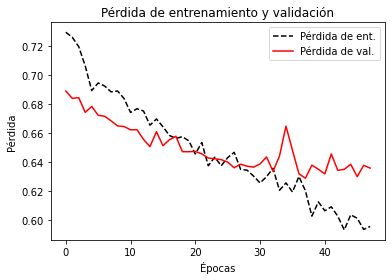

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


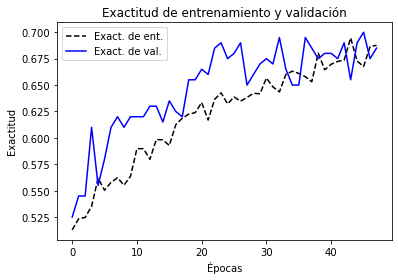

In [ ]:
#np.save(history, "history.np")
plot_history(history)

## Analizar los resultados

### Realizar evaluación sobre todo el conjunto de validación

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
modelo_personalizado.load_weights(weight_path)

#pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

#for i in range(math.floor(n_val_examples/batch_size)):
#    (xval, yval)val_gen.next()
#    predy = new_model.predict(valX, batch_size = 32, verbose = True)

pred_Y = modelo_personalizado.predict(valX, batch_size = 32, verbose = True)
#pred_Y.shape

#print(pred_Y)

200/200 [==============================] - 1s 3ms/sample


### Evaluar diversas métricas

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


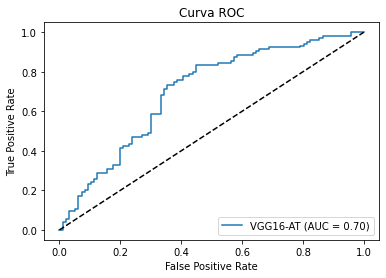

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import auc

# Graficar ROC curve
fpr, tpr, thresholds = roc_curve(valY, pred_Y, pos_label = 1)

roc_auc = auc(fpr, tpr)

display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name= model_name + '-AT')
display.plot()  
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.savefig(model_name + '_roc.eps', format='eps')
plt.show()


In [ ]:
#y_pred_keras = keras_model.predict(X_test).ravel()

precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

auc_keras = auc(fpr, tpr)

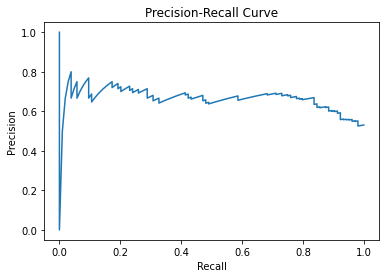

In [ ]:
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig(model_name + '_prc.eps', format='eps')
plt.show()

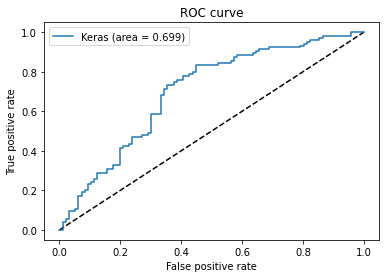

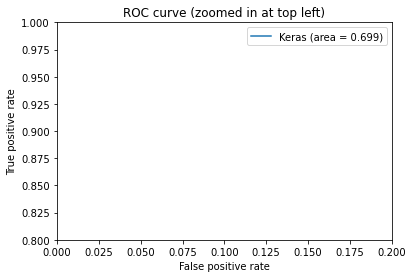

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()


### Metric optimization

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
def sensibility(tp, fn):
    return tp / (tp + fn)

def specificity(tn, fp):
    return tn / (tn + fp)

def getSensAndSpec(threshold, predictions):
    over_threshold = predictions >= threshold
    over_threshold = [[1] if result[0] else [0] for result in over_threshold]
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(valY, over_threshold).ravel()
    return [sensibility(tp, fn), specificity(tn, fp)]

def getF1(threshold, predictions):
    over_threshold = predictions >= threshold
    over_threshold = [[1] if result[0] else [0] for result in over_threshold]
    return f1_score(valY, over_threshold, average='macro')

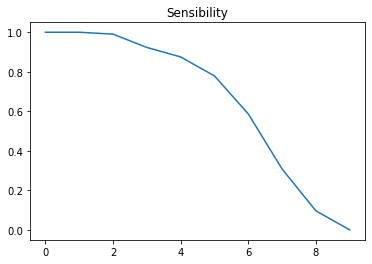

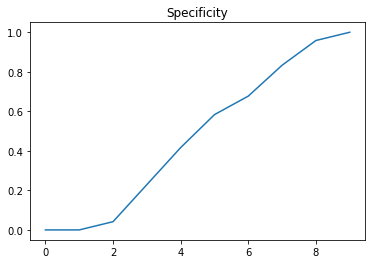

In [ ]:
# Optimization
Threshold = np.arange(0,1,0.1)

SensSpec = np.array([getSensAndSpec(thres, pred_Y) for thres in Threshold])

plt.plot(SensSpec[:,0])
plt.title('Sensibility')
plt.show()

plt.plot(SensSpec[:,1])
plt.title('Specificity')
plt.show()

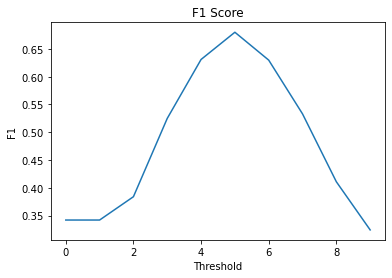

In [ ]:
# Optimization
F1s = np.array([getF1(thres, pred_Y) for thres in Threshold])
plot_f1s(F1s)

### Performance of the selected threshold

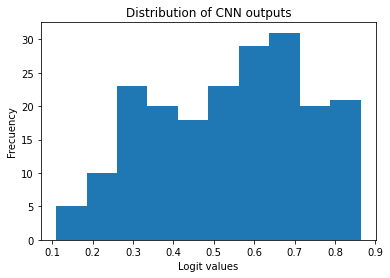

In [ ]:
# Plot output distributions

plt.hist(pred_Y, bins=10)
plt.title('Distribution of CNN outputs')
plt.ylabel('Frecuency')
plt.xlabel('Logit values')
plt.savefig(model_name + '_histogram.eps', format='eps')
plt.show()


In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# I am selecting sensibility as my target metric since I want to reduce false negatives. 
# Even though the best F1 score is obtained when the threshold is equal to 0.5
# I selects threshold 0.4 because it shows a better sensibility
YOUR_THRESHOLD=0.5

over_threshold = pred_Y >= YOUR_THRESHOLD
#print(over_threshold[:10])
over_threshold = [[1] if result[0] else [0] for result in over_threshold]
#print(over_threshold[:10])

tn, fp, fn, tp = sklearn.metrics.confusion_matrix(valY, over_threshold).ravel()

print('Sensibility:', sensibility(tp, fn))
print('Specificity:', specificity(tn, fp))



Sensibility: 0.7788461538461539
Specificity: 0.5833333333333334


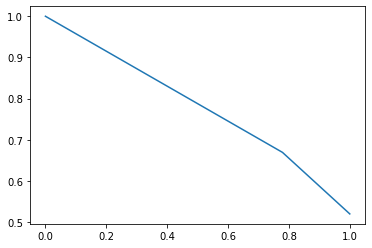

In [ ]:
precision, recall, thresholds = precision_recall_curve(valY, over_threshold)
plt.plot(recall, precision)
plt.show()

In [ ]:
f1_score(valY, over_threshold, average='macro')

0.6799999999999999

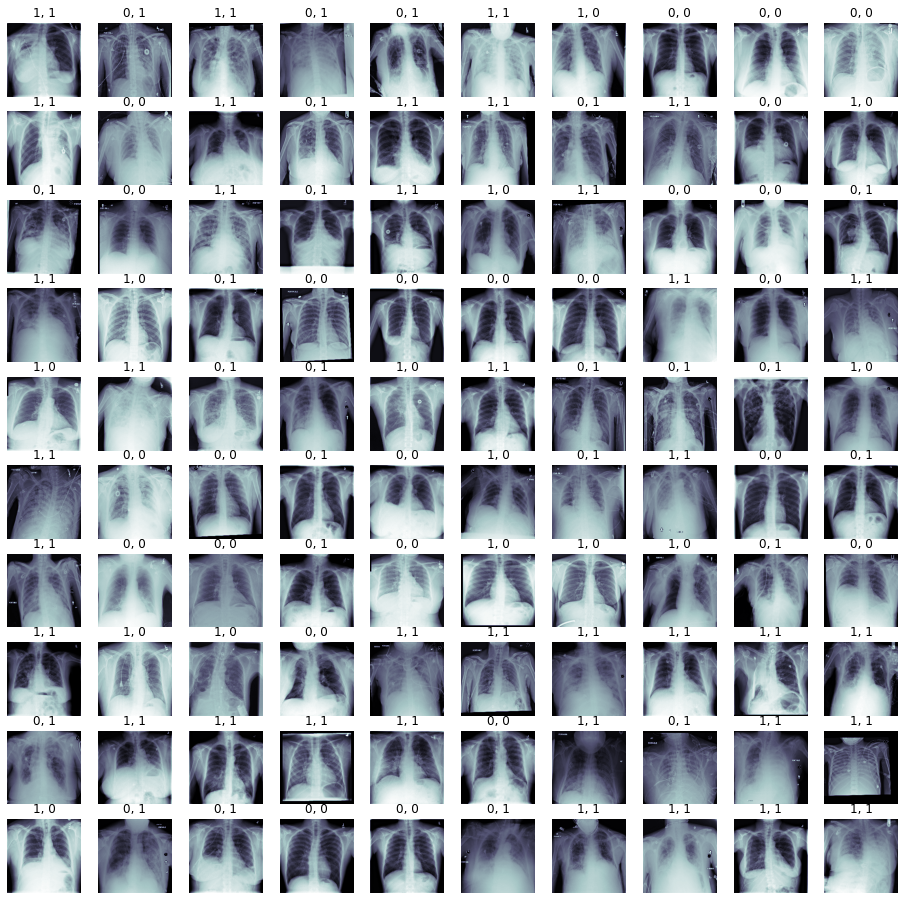

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    #valY
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1.: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = new_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)